# Trying to integrate using the pipleline described in the paper methods

In [1]:
# Python packages
import os
import seaborn as sns
import anndata as ad
import glob
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib_venn import venn2
import snapatac2 as snap

In [2]:
# List h5ads to integrate
results_paths = ["/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/annotation/27Oct23/snapatac2/cellcommander_recipe"]
outdir_path = "/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/annotation/27Oct23/snapatac2/cellcommander_recipe/integrate/publication"

In [3]:
# List h5ads to integrate
h5ad_paths = []
for results_path in results_paths:
    h5ad_paths += sorted(glob.glob(os.path.join(results_path, "*", "clustered.h5ad"))) # snapatac2
len(h5ad_paths), h5ad_paths

(5,
 ['/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/annotation/27Oct23/snapatac2/cellcommander_recipe/MM129/clustered.h5ad',
  '/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/annotation/27Oct23/snapatac2/cellcommander_recipe/MM157/clustered.h5ad',
  '/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/annotation/27Oct23/snapatac2/cellcommander_recipe/MM166/clustered.h5ad',
  '/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/annotation/27Oct23/snapatac2/cellcommander_recipe/MM168/clustered.h5ad',
  '/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/annotation/27Oct23/snapatac2/cellcommander_recipe/MM290/clustered.h5ad'])

# Load and concatenate the data

In [4]:
# Read in samples
adata_list = []
samples = []
for h5ad_path in h5ad_paths:

    # Load in a sample with just the counts
    sample = h5ad_path.split("/")[-2]  # snapatac2
    print(f"Loading {sample}")
    adata = sc.read_h5ad(h5ad_path)
    adata.obs.index = sample + "_" + adata.obs.index
    adata.obs.index = adata.obs.index.str.replace("-1", "")  # needed this for this case
    adata_cp = sc.AnnData(adata.X.copy(), obs=adata.obs.copy(), var=adata.var.copy())
    raw = adata_cp.copy()

    # Preprocess that sample
    print(f"Preprocessing {h5ad_path}")
    sc.pp.normalize_total(adata_cp, target_sum=1e4)
    adata_cp = adata_cp[:, adata_cp.var.selected]
    adata_cp.obs['log_usable_counts'] = np.log(raw[:, raw.var.selected].X.sum(axis=1).A1)
    print("Regressing out log_usable_counts, this may take a while...")
    sc.pp.regress_out(adata_cp, keys=['log_usable_counts'])

    # Add to list and save
    print(f"Saving processed to {outdir_path}")
    adata_cp.write(os.path.join(outdir_path, '{}_processed.h5ad'.format(sample)))
    adata_list.append(adata_cp)
    samples.append(sample)

    # Save raw version that will be useful for visualization
    print(f"Saving raw to {outdir_path}")
    sc.pp.normalize_total(raw, target_sum=1e4)
    sc.pp.log1p(raw)
    raw.write(os.path.join(outdir_path, '{}_raw.h5ad'.format(sample)))

Loading MM129
Preprocessing /cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/annotation/27Oct23/snapatac2/cellcommander_recipe/MM129/clustered.h5ad


/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/tmp/ipykernel_1186862/3841069834.py:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_cp.obs['log_usable_counts'] = np.log(raw[:, raw.var.selected].X.sum(axis=1).A1)


Regressing out log_usable_counts, this may take a while...


/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:619: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if keys[0] in adata.obs_keys() and is_categorical_dtype(adata.obs[keys[0]]):


In [10]:
# Concat samples
adata_concat = ad.concat(adata_list, label="sample", keys=samples)
adata_concat.obs["sample"].value_counts()

/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/anndata/_core/merge.py:217: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(dtype):


sample
MM129    18508
Name: count, dtype: int64

# Get an initial embedding

In [24]:
# Scale
sc.pp.scale(adata_concat)

2023-10-27 12:37:46 - INFO - Selected 50000 features.


In [25]:
# Run PCA
sc.tl.pca(adata_concat, zero_center=True, svd_solver='arpack', random_state=1234)

# Batch correct that embedding with Harmony

In [ ]:
# 
pc = pd.DataFrame(adata_norm.obsm['X_pca'], columns=['PC{}'.format(i) for i in range(1,51)], index=adata_norm.obs.index)
metadata = pd.DataFrame(index=adata_norm.obs.index)
metadata['donor'] = [i.split('_')[0] for i in metadata.index]

In [ ]:
%%R -i pc -i metadata -o harmonized
library(harmony)
library(magrittr)

# run Harmony on the PCs
harmonized <- HarmonyMatrix(pc, metadata, c('donor'), do_pca=FALSE)
harmonized <- data.frame(harmonized)

# UMAP embedding

In [ ]:
sc.pp.neighbors(adata_norm, n_neighbors=30, method='umap', metric='cosine', random_state=1234, n_pcs=50)
sc.tl.leiden(adata_norm, resolution=1.5, random_state=1234)
sc.tl.umap(adata_norm, min_dist=0.3, random_state=1234)

In [33]:
# Load in previous adata
adata_prev = sc.read_h5ad("/cellar/users/aklie/data/datasets/Zhu2023_sc-islet_snATAC-seq/annotation/04Jul23/GSE202498_final_cluster.h5ad")
adata_prev

AnnData object with n_obs × n_vars = 65255 × 54493
    obs: 'batch', 'donor', 'duplicated_reads', 'frac_duplicated_reads', 'frac_mito_reads', 'frac_promoters_used', 'frac_reads_in_peaks', 'frac_reads_in_promoters', 'log10_n_counts', 'log10_n_peaks', 'log10_usable_counts', 'log_usable_counts', 'n_counts', 'n_peaks', 'norm_log_counts', 'reads_in_peaks', 'reads_in_promoters', 'total_sequenced_reads', 'tss_used', 'unique_mito_reads', 'unique_usable_reads', 'leiden'
    uns: 'leiden', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [34]:
cellid_dict = {
    "0": "SC.alpha",
    "1": "SC.EC",
    "2": "PP1",
    "3": "SC.beta",
    "4": "ENP1",
    "5": "ENP3",
    "6": "ENP2",
    "7": "PP2",
    "8": "ENP.alpha",
    "9": "SC.delta",
}

In [35]:
adata_prev.obs["cellid"] = adata_prev.obs["leiden"].map(cellid_dict)

In [36]:
cellid_map = adata_prev.obs["cellid"]

In [37]:
adata_concat.obs["cellid"] = adata_concat.obs.index.map(cellid_map).astype("category")

In [38]:
adata_concat.obs["cellid"].value_counts()

cellid
SC.alpha     12096
SC.EC        11908
PP1           7917
SC.beta       7214
ENP3          5109
ENP1          5107
ENP2          2679
PP2           1958
ENP.alpha     1309
SC.delta      1064
Name: count, dtype: int64

/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/minicon

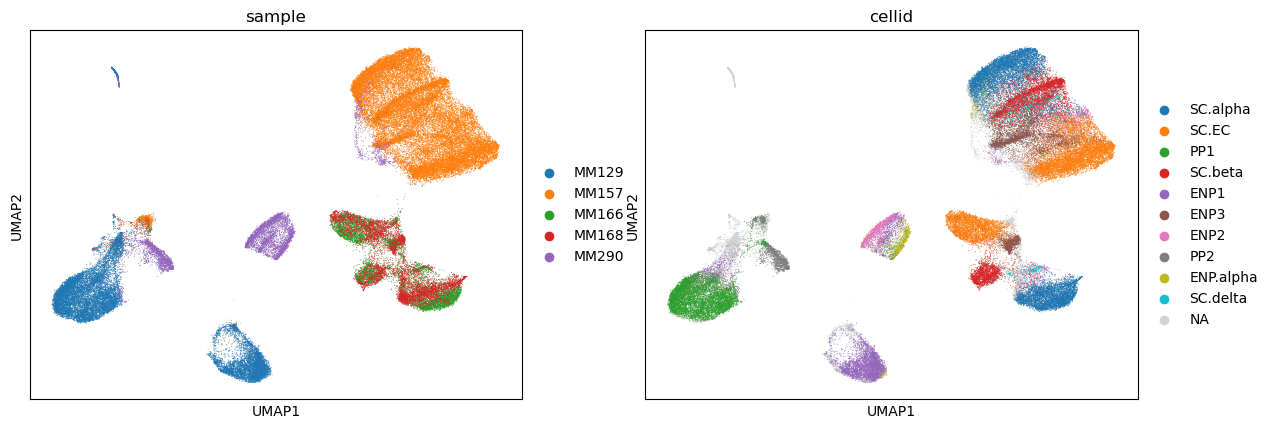

In [39]:
sc.pl.umap(adata_concat, color=["sample", "cellid"])

In [41]:
snap.pp.harmony(adata_concat, batch="sample", max_iter_harmony=20)

2023-10-27 12:47:28,624 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-10-27 12:47:28 - INFO - Computing initial centroids with sklearn.KMeans...
2023-10-27 12:47:45,260 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-10-27 12:47:45 - INFO - sklearn.KMeans initialization complete.
2023-10-27 12:47:46,152 - harmonypy - INFO - Iteration 1 of 20
2023-10-27 12:47:46 - INFO - Iteration 1 of 20
2023-10-27 12:48:29,860 - harmonypy - INFO - Iteration 2 of 20
2023-10-27 12:48:29 - INFO - Iteration 2 of 20
2023-10-27 12:48:45,242 - harmonypy - INFO - Iteration 3 of 20
2023-10-27 12:48:45 - INFO - Iteration 3 of 20
2023-10-27 12:48:58,446 - harmonypy - INFO - Converged after 3 iterations
2023-10-27 12:48:58 - INFO - Converged after 3 iterations


In [42]:
snap.tl.umap(adata_concat, use_rep="X_spectral_harmony")

/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning:

The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning

/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored

/cellar/users/aklie/opt/miniconda3/envs/scverse-py39-R431/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: Futur

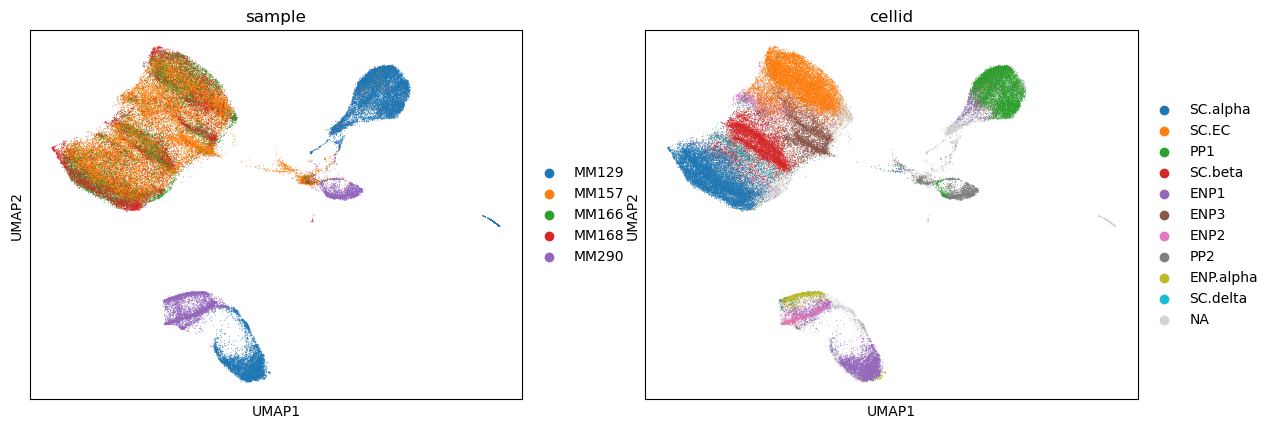

In [44]:
sc.pl.umap(adata_concat, color=["sample", "cellid"])

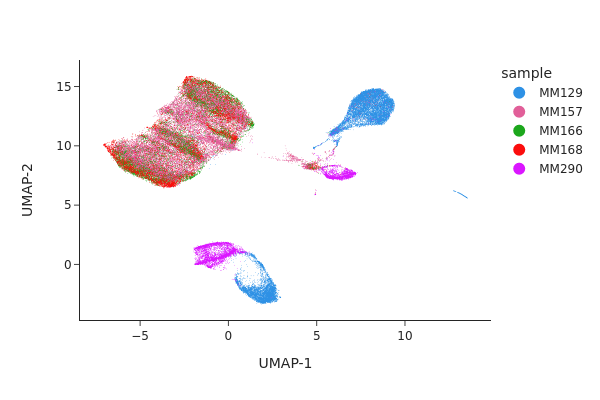

In [43]:
snap.pl.umap(adata_concat, color="sample", interactive=False)